In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
from math import sin, cos, pi
import matplotlib.pyplot as plt
import copy
import joblib
from pathlib import Path


In [ ]:
class HamsterDataset(Dataset):
  def __init__(self, csv_file):
    self.df = pd.read_csv(csv_file)

    self.features = self.df[["Hour", "Minute", "Second", "Temperature(C)", "Humidity(%)", "Light(lux)"]]
    # self.features = self.df[["Temperature(C)", "Humidity(%)", "Light(lux)"]]
    self.labels = self.df["Behavior"]

    self.scalar = StandardScaler()
    self.features = self.scalar.fit_transform(self.features)

    self.label_encoder = LabelEncoder()
    self.labels = self.label_encoder.fit_transform(self.labels)

    self.features = torch.tensor(self.features, dtype=torch.float32)
    self.labels = torch.tensor(self.labels, dtype=torch.long)

    print("Behavior Label Mapping:")
    for idx, class_name in enumerate(self.label_encoder.classes_):
        print(f"{idx}: {class_name}")

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    return self.features[idx], self.labels[idx]


path = "../data/hamster_behavior.csv"
a = HamsterDataset(path)
a.labels
joblib.dump(a.scalar, './scaler/scaler.save')

Behavior Label Mapping:
0: active
1: eating
2: sleeping


['./scalar/scaler.save']

In [6]:
class NeuralNetwork(nn.Module):
  def __init__(self, num_of_features = 6, num_of_output_classes = 3):
    super(NeuralNetwork, self).__init__()

    self.hidden_layer_1 = nn.Linear(num_of_features, 64)
    self.bn1 = nn.BatchNorm1d(64)

    # self.hidden_layer_2 = nn.Linear(64, 64)
    # self.bn2 = nn.BatchNorm1d(64)

    self.hidden_layer_3 = nn.Linear(64, 32)
    self.bn3 = nn.BatchNorm1d(32)

    self.output_layer = nn.Linear(32, num_of_output_classes)

    self.loss_function = nn.CrossEntropyLoss()
    self.optimizer = optim.Adam(self.parameters(), lr=0.0001, weight_decay=1e-4)

    self.dropout = nn.Dropout(p=0.4)

  def forward(self, input_tensor):
    x = self.hidden_layer_1(input_tensor)
    x = self.bn1(x)
    x = F.relu(x)
    x = self.dropout(x)

    # x = self.hidden_layer_2(x)
    # x = self.bn2(x)
    # x = F.relu(x)
    # x = self.dropout(x)

    x = self.hidden_layer_3(x)
    x = self.bn3(x)
    x = F.relu(x)

    out = self.output_layer(x)
    return out

  def train_model(self, train_loader, val_loader=None, num_of_epochs=30, patience=5):
    self.train()

    train_losses = []
    val_losses = []
    val_accuracies = []

    best_loss = float("inf")
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(num_of_epochs):
      total_loss_for_epoch = 0

      for input_batch, target_label in train_loader:
        self.optimizer.zero_grad()

        pred_output = self(input_batch)
        loss = self.loss_function(pred_output, target_label)

        loss.backward()
        self.optimizer.step()

        total_loss_for_epoch += loss.item()

      average_loss = total_loss_for_epoch / len(train_loader)
      train_losses.append(average_loss)
      print(f"Epoch: {epoch + 1}/{num_of_epochs}, Loss: {average_loss:.4f}")

      if val_loader:
        val_loss, val_acc = self.evaluate_loss_and_accuracy(val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f" | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%", end='')

        if val_loss < best_loss:
          best_loss = val_loss
          best_model_state = copy.deepcopy(self.state_dict())
          torch.save(best_model_state, '../model/hamster_behavior_best_model.pt')
          # model_save_path = '/content/hamster_behavior_model_123.pt'
          # torch.save({
          #     "model_state_dict": copy.deepcopy(self.state_dict())
          # }, model_save_path)
          epochs_no_improve = 0
        else:
          epochs_no_improve += 1
          if epochs_no_improve >= patience:
            print("\n Early stopping triggered. Restoring best model...")
            self.load_state_dict(torch.load('../model/hamster_behavior_best_model.pt'))
            break
    self.plot_training_progress(train_losses, val_losses, val_accuracies)

  def eval_model(self, test_loader):
    self.eval()

    total_samples = 0
    correct_pred = 0

    with torch.no_grad():
      for input_batch, target_label in test_loader:
        pred_output = self(input_batch)
        _, predicted_labels = torch.max(pred_output, 1)

        total_samples += target_label.size(0)
        correct_pred += (predicted_labels == target_label).sum().item()

    accuracy = correct_pred / total_samples
    print(f"Accuracy: {accuracy * 100:.2f}%")

  def evaluate_loss_and_accuracy(self, loader):
    self.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
      for input_batch, target_label in loader:
        output = self(input_batch)
        loss = self.loss_function(output, target_label)
        total_loss += loss.item()

        _, preds = torch.max(output, 1)
        correct += (preds == target_label).sum().item()
        total += target_label.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

  def plot_training_progress(self, train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', marker='o')
    if val_losses:
        plt.plot(epochs, val_losses, label='Val Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    # Accuracy plot
    if val_accuracies:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, val_accuracies, label='Val Accuracy', color='green', marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Validation Accuracy over Epochs')
        plt.legend()

    plt.tight_layout()
    plt.show()

Behavior Label Mapping:
0: active
1: eating
2: sleeping
Epoch: 1/200, Loss: 1.1011
 | Val Loss: 1.0845 | Val Acc: 36.67%Epoch: 2/200, Loss: 1.0379
 | Val Loss: 1.0337 | Val Acc: 52.00%Epoch: 3/200, Loss: 0.9923
 | Val Loss: 1.0157 | Val Acc: 52.33%Epoch: 4/200, Loss: 0.9707
 | Val Loss: 1.0054 | Val Acc: 53.83%Epoch: 5/200, Loss: 0.9557
 | Val Loss: 0.9958 | Val Acc: 54.50%Epoch: 6/200, Loss: 0.9429
 | Val Loss: 0.9871 | Val Acc: 54.50%Epoch: 7/200, Loss: 0.9320
 | Val Loss: 0.9782 | Val Acc: 55.17%Epoch: 8/200, Loss: 0.9213
 | Val Loss: 0.9687 | Val Acc: 56.00%Epoch: 9/200, Loss: 0.9107
 | Val Loss: 0.9584 | Val Acc: 56.50%Epoch: 10/200, Loss: 0.9002
 | Val Loss: 0.9472 | Val Acc: 56.67%Epoch: 11/200, Loss: 0.8896
 | Val Loss: 0.9360 | Val Acc: 57.00%Epoch: 12/200, Loss: 0.8789
 | Val Loss: 0.9243 | Val Acc: 56.83%Epoch: 13/200, Loss: 0.8686
 | Val Loss: 0.9129 | Val Acc: 57.17%Epoch: 14/200, Loss: 0.8586
 | Val Loss: 0.9030 | Val Acc: 57.17%Epoch: 15/200, Loss: 0.8489
 | Val Loss: 0.

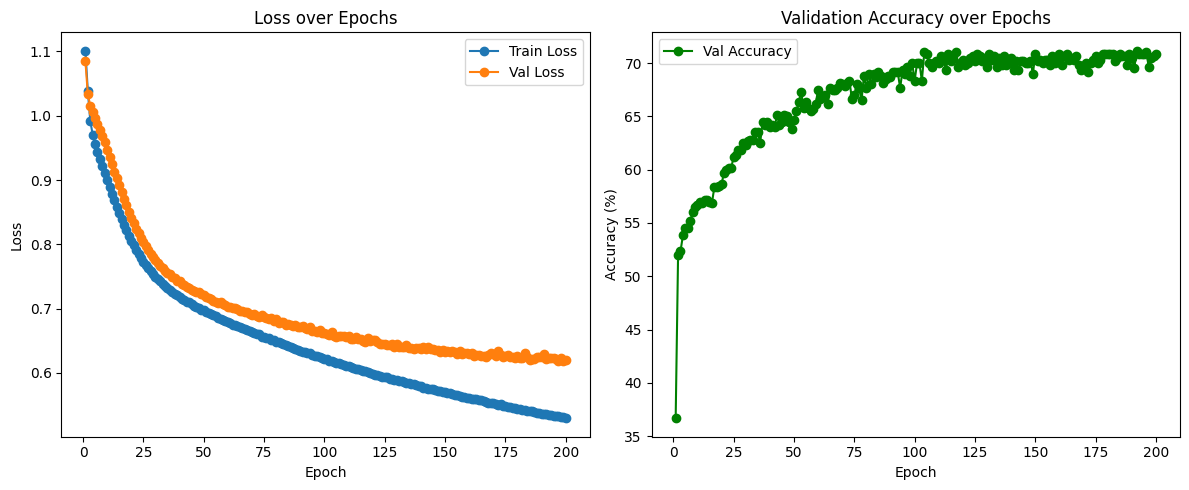

Accuracy: 70.83%
Model saved to ../model/hamster_behavior_model.pt


In [7]:
if __name__ == "__main__":
  dataset = HamsterDataset('../data/hamster_behavior.csv')

  train_size = int(0.8 * len(dataset))
  test_size = len(dataset) - train_size
  train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  model = NeuralNetwork()
  model.train_model(train_loader, val_loader=test_loader, num_of_epochs=200, patience=20)
  model.eval_model(test_loader)

  model_save_path = '../model/hamster_behavior_model.pt'
  torch.save({
        "model_state_dict": model.state_dict()
    }, model_save_path)
  print(f"Model saved to {model_save_path}")

In [8]:
def preprocess_single_sample_with_time(sample_dict, scaler):
    df_input = pd.DataFrame([[
        sample_dict["Hour"],
        sample_dict["Minute"],
        sample_dict["Second"],
        sample_dict["Temperature"],
        sample_dict["Humidity"],
        sample_dict["Light"]
    ]], columns=["Hour", "Minute", "Second", "Temperature(C)", "Humidity(%)", "Light(lux)"])

    normalized = scaler.transform(df_input)

    input_tensor = torch.tensor(normalized, dtype=torch.float32)
    return input_tensor

In [10]:
data_list = []

cur_df = pd.read_csv('../data/hamster_behavior.csv')

for _, row in cur_df.head(100).iterrows():
    new_data = {
        "Hour": int(row['Hour']),
        "Minute": int(row['Minute']),
        "Second": int(row['Second']),
        "Temperature": float(row['Temperature(C)']),
        "Humidity": float(row['Humidity(%)']),
        "Light": int(row['Light(lux)'])
    }
    data_list.append(new_data)

data_list

[{'Hour': 0,
  'Minute': 1,
  'Second': 11,
  'Temperature': 28.1,
  'Humidity': 62.9,
  'Light': 1527},
 {'Hour': 0,
  'Minute': 7,
  'Second': 56,
  'Temperature': 28.1,
  'Humidity': 54.0,
  'Light': 1595},
 {'Hour': 0,
  'Minute': 21,
  'Second': 39,
  'Temperature': 31.4,
  'Humidity': 57.5,
  'Light': 1265},
 {'Hour': 0,
  'Minute': 33,
  'Second': 45,
  'Temperature': 25.4,
  'Humidity': 61.8,
  'Light': 1998},
 {'Hour': 0,
  'Minute': 38,
  'Second': 23,
  'Temperature': 29.7,
  'Humidity': 60.5,
  'Light': 711},
 {'Hour': 0,
  'Minute': 54,
  'Second': 23,
  'Temperature': 28.6,
  'Humidity': 62.2,
  'Light': 1738},
 {'Hour': 1,
  'Minute': 3,
  'Second': 53,
  'Temperature': 26.3,
  'Humidity': 65.0,
  'Light': 2335},
 {'Hour': 1,
  'Minute': 7,
  'Second': 25,
  'Temperature': 27.1,
  'Humidity': 56.1,
  'Light': 987},
 {'Hour': 1,
  'Minute': 24,
  'Second': 8,
  'Temperature': 28.4,
  'Humidity': 62.3,
  'Light': 1940},
 {'Hour': 1,
  'Minute': 34,
  'Second': 28,
  'Tempe

In [ ]:
pred = []
label = []

#got label from df
for _, row in cur_df.head(100).iterrows():
  label.append(row['Behavior'])
  
index = 0
correct = 0

for new_data in data_list:
  # print(new_data)
  scaler = joblib.load('./scaler/scaler.save')

  input_tensor = preprocess_single_sample_with_time(new_data, scaler)
  # print(input_tensor)

  # Load
  model = NeuralNetwork(num_of_features=6, num_of_output_classes=3)
  checkpoint = torch.load("../model/hamster_behavior_model.pt")
  model.load_state_dict(checkpoint["model_state_dict"])
  # model.load_state_dict(torch.load("../model/hamster_behavior_best_model.pt"))
  model.eval()

  # Pred
  with torch.no_grad():
      output = model(input_tensor)
      predicted_class = torch.argmax(output, dim=1).item()

  label_mapping = {0: "active", 1: "eating", 2: "sleeping"}
  s = 'TRUE' if label_mapping[predicted_class] == label[index] else 'FALSE'
  correct = correct + 1 if s == 'TRUE' else correct
  print(f"Predict: {label_mapping[predicted_class]:<20} Label: {label[index]:<20} ==> {s:<20}")
  index += 1
  pred.append(label_mapping[predicted_class])

print(f"Accuracy: {correct / len(pred) * 100}%")

Predict: sleeping             Label: sleeping             ==> TRUE                
Predict: sleeping             Label: sleeping             ==> TRUE                
Predict: sleeping             Label: active               ==> FALSE               
Predict: sleeping             Label: active               ==> FALSE               
Predict: sleeping             Label: sleeping             ==> TRUE                
Predict: sleeping             Label: sleeping             ==> TRUE                
Predict: sleeping             Label: sleeping             ==> TRUE                
Predict: sleeping             Label: sleeping             ==> TRUE                
Predict: sleeping             Label: sleeping             ==> TRUE                
Predict: active               Label: sleeping             ==> FALSE               
Predict: sleeping             Label: sleeping             ==> TRUE                
Predict: active               Label: active               ==> TRUE                
Pred